In [1]:
# Add DEVENV_PATH to the path so that we can import the modules
import sys
from os import getenv
import numpy as np
sys.path.append(getenv("DEVENV_ROOT"))

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
import seaborn as sns
import greenflow.analysis as an
from entrypoint import load_gin
from greenflow.utils import convert_to_mib

cutoff = "2024-12-16T03:15:35.626996+01:00"
cutoff_end = "2025-01-06T03:15:35.626996+01:00"

load_gin(exp_name="ingest-kafka", test=False)


[WARNING]: failed to patch stdout/stderr for fork-safety: 'OutStream' object
has no attribute 'buffer'
[WARNING]: failed to reconfigure stdout/stderr with the replace error handler:
'OutStream' object has no attribute 'reconfigure'


In [2]:
import matplotlib.pyplot as plt

def safety_analysis(data):
    # Function to create the graph for a specific system
    def _safety(data, system_name):
        # Filter data for the specific system
        system_data = data

        # Create figure and axis
        fig, ax = plt.subplots(figsize=(12, 8))

        cmap = plt.cm.RdYlGn

        # Create scatter plot for all points except the last point for each message size
        scatter = ax.scatter(
            system_data["messageSize"][:-1],
            system_data["observed_throughput"][:-1],
            # c=system_data["throughput_gap_percentage"][:-1],
            # cmap=cmap,
            s=50,
        )

        # Create scatter plot for the last point of each message size with a different marker style
        last_points = system_data.groupby("messageSize").first()
        ax.scatter(
            last_points.index,
            last_points["observed_throughput"],
            s=100,
            marker="o",
            linewidths=1,
        )

        for idx, row in last_points.iterrows():
            ax.annotate(f"{int(row['observed_throughput'])}", (idx, row['observed_throughput']), 
                        textcoords="offset points", xytext=(20, 40), ha='center',
                        arrowprops=dict(arrowstyle="-", color='black', linewidth=0.5, shrinkA=0, shrinkB=0))

        # Sort the last points by messageSize
        last_points = last_points.sort_index()

        # Connect the last points with a line
        ax.plot(last_points.index, last_points["observed_throughput"], linestyle="-", color="black")

        # Fill the area below the line as "Safe"
        ax.fill_between(last_points.index, last_points["observed_throughput"], color="green", alpha=0.2, label="Safe")

        # Fill the area above the line as "Not safe"
        ax.fill_between(last_points.index, last_points["observed_throughput"], y2=ax.get_ylim()[1], color="red", alpha=0.2, label="Not safe")

        # Add color bar
        # plt.colorbar(scatter, ax=ax, label="Throughput Gap (%)", extend="min")

        ax.set_title(f"Observed Throughput vs Message Size for {system_name}")
        ax.set_xlabel("Message Size (bytes)")
        ax.set_ylabel("Observed Throughput (messages/sec)")

        # Add legend
        ax.legend()

        plt.tight_layout()
        plt.show()

        return last_points


    kafka_last_points = _safety(data[data["exp_name"] == "ingest-kafka"], "Kafka")
    redpanda_last_points = _safety(data[data["exp_name"] == "ingest-redpanda"], "Redpanda")

    # Create a new figure for comparing the safety lines
    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot the safety lines for Kafka and Redpanda
    ax.plot(kafka_last_points.index, kafka_last_points["observed_throughput"], linestyle="-", color="blue", label="Kafka")
    ax.plot(redpanda_last_points.index, redpanda_last_points["observed_throughput"], linestyle="-", color="red", label="Redpanda")

    # Fill the region that can be handled by both Kafka and Redpanda
    ax.fill_between(kafka_last_points.index, kafka_last_points["observed_throughput"], color="green", alpha=0.2, label="Handled by both")

    # Fill the region that can be handled by Redpanda but not Kafka
    ax.fill_between(kafka_last_points.index, kafka_last_points["observed_throughput"], redpanda_last_points["observed_throughput"], where=(redpanda_last_points["observed_throughput"] > kafka_last_points["observed_throughput"]), color="yellow", alpha=0.2, label="Handled by Redpanda only")

    # Fill the region that cannot be handled by both
    ax.fill_between(redpanda_last_points.index, redpanda_last_points["observed_throughput"], y2=ax.get_ylim()[1], color="red", alpha=0.2, label="Not handled by both")

    ax.set_title("Safety Lines Comparison: Kafka vs Redpanda")
    ax.set_xlabel("Message Size (bytes)")
    ax.set_ylabel("Observed Throughput (messages/sec)")

    # Add legend
    ax.legend()

    plt.tight_layout()
    plt.show()


In [3]:
common = dict(type="safetyCurve", cutoff_begin=cutoff, cutoff_end=cutoff_end, partitions=1)
grappe_1 = an.full_analytical_pipeline(cluster="grappe", **common)
ovhnvme_1 = an.full_analytical_pipeline(cluster="ovhnvme", **common)
taurus_1 = an.full_analytical_pipeline(cluster="taurus", **common)

In [4]:
# common = dict(type="safetyCurve", cutoff_begin=cutoff, cutoff_end=cutoff_end, partitions=1)
# grappe_1 = an.full_analytical_pipeline_nocache(cluster="grappe", **common)
# ovhnvme_1 = an.full_analytical_pipeline_nocache(cluster="ovhnvme", **common)
# taurus_1 = an.full_analytical_pipeline_nocache(cluster="taurus", **common)

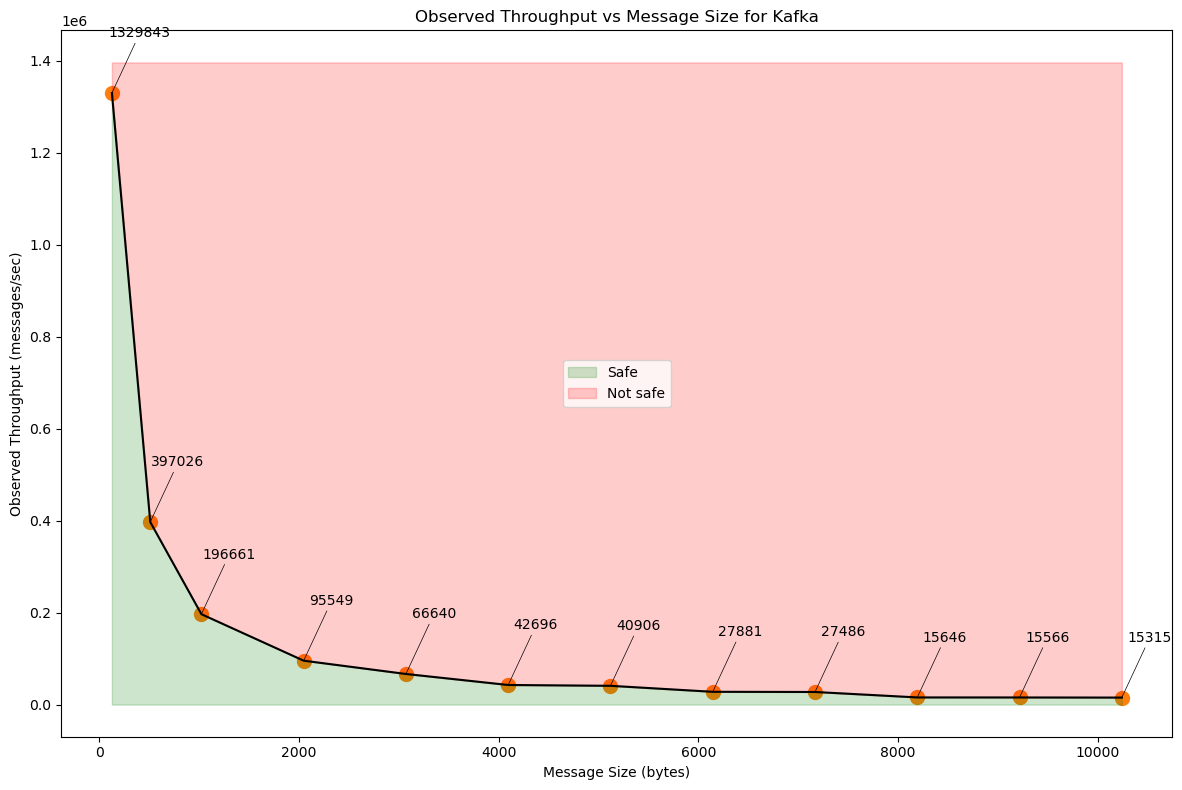

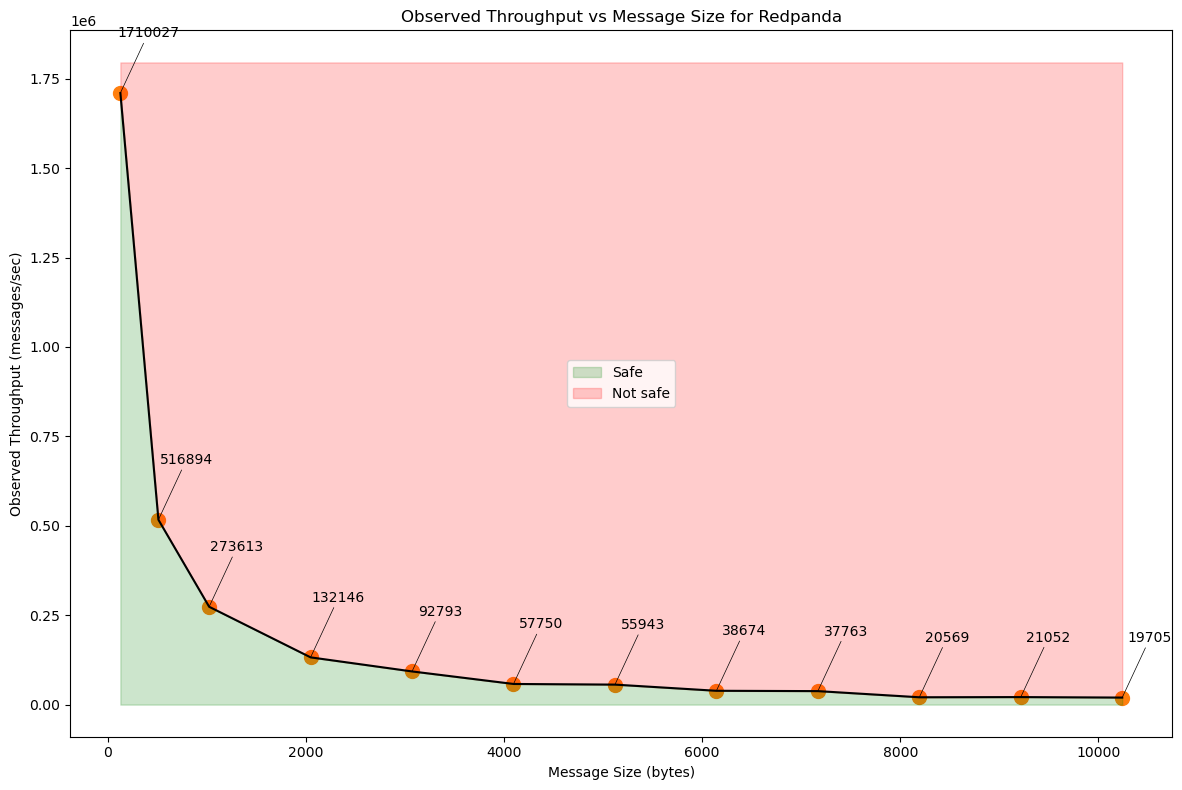

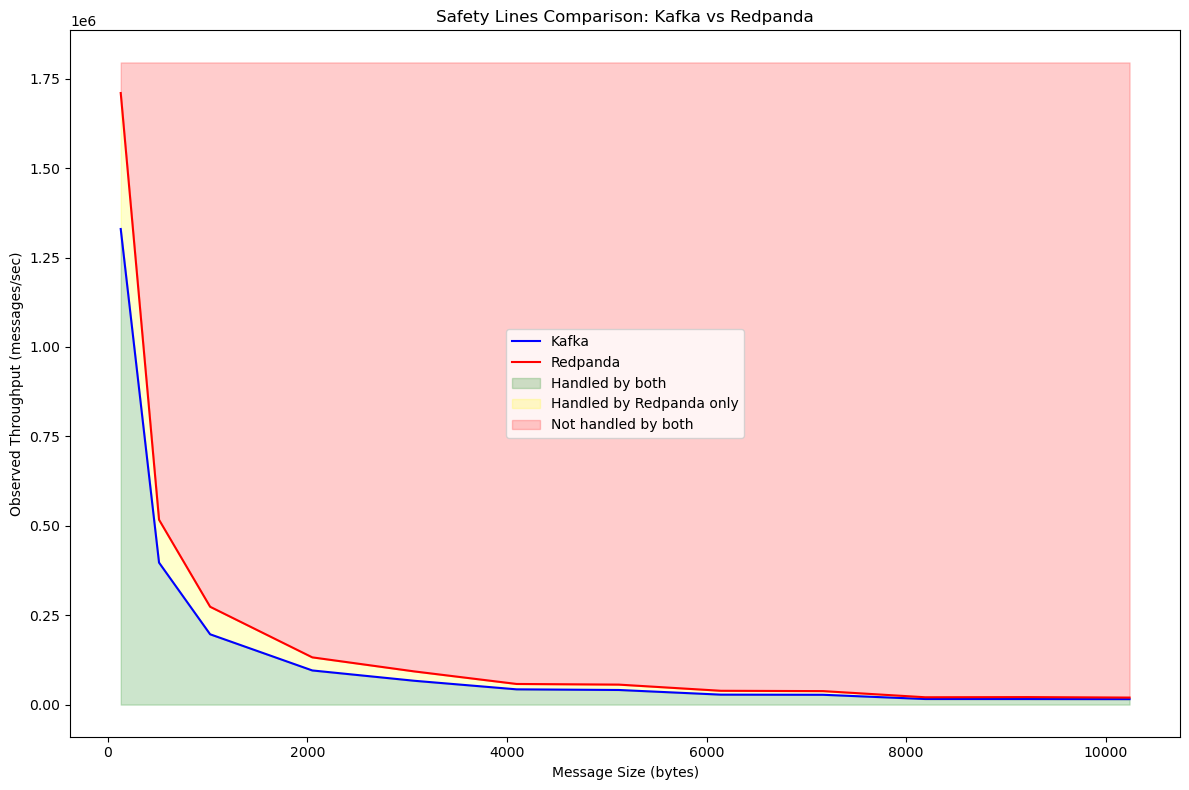

In [5]:
safety_analysis(ovhnvme_1)

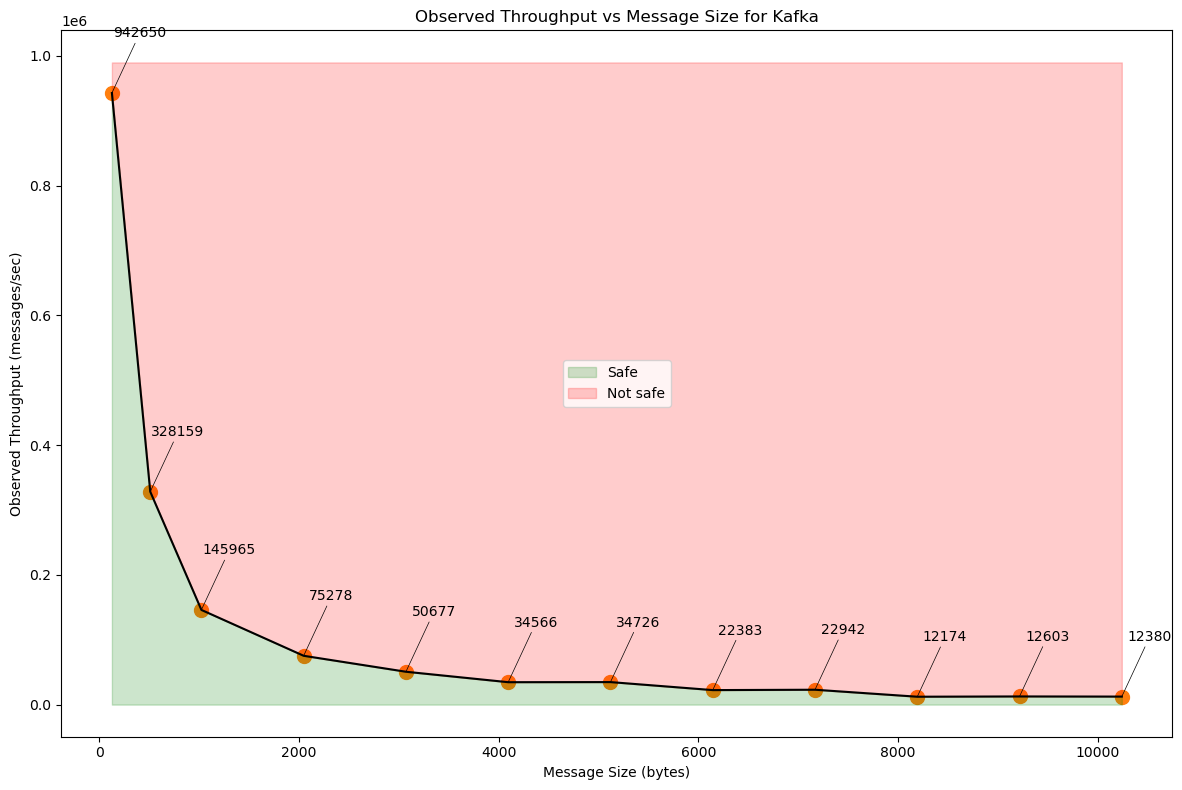

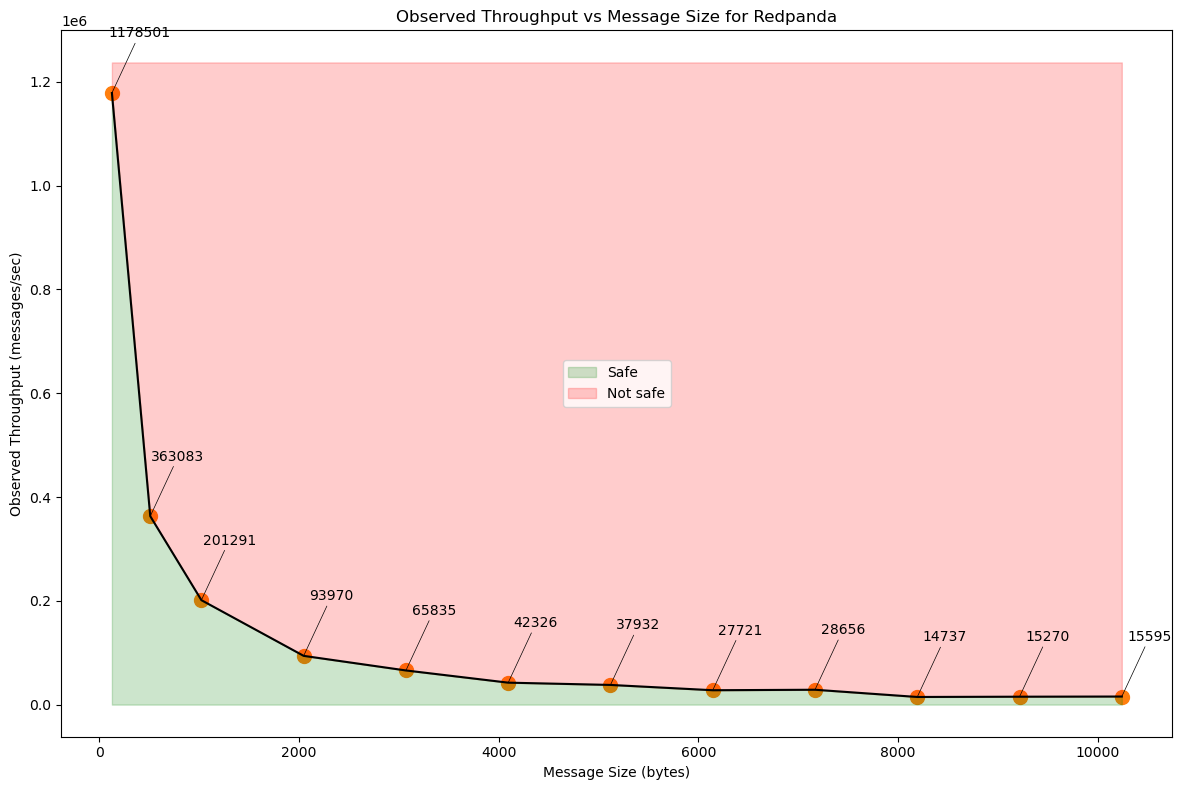

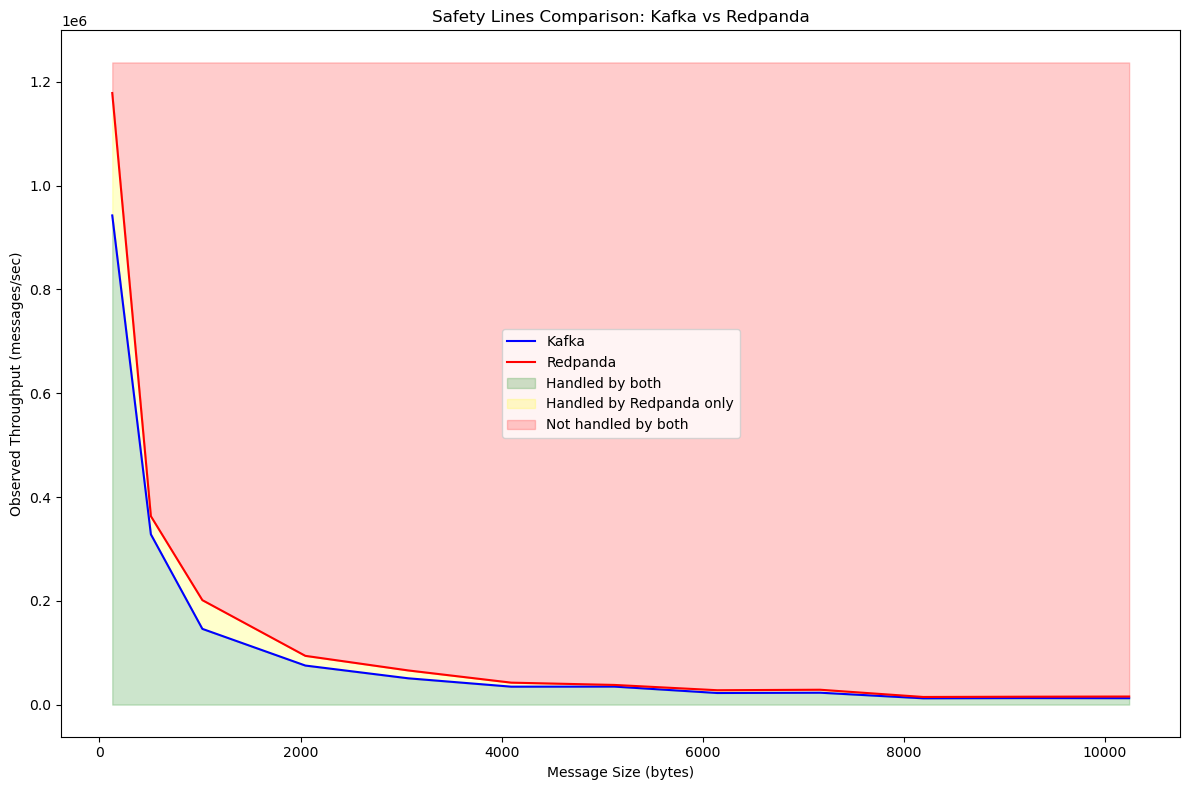

In [6]:
safety_analysis(grappe_1)

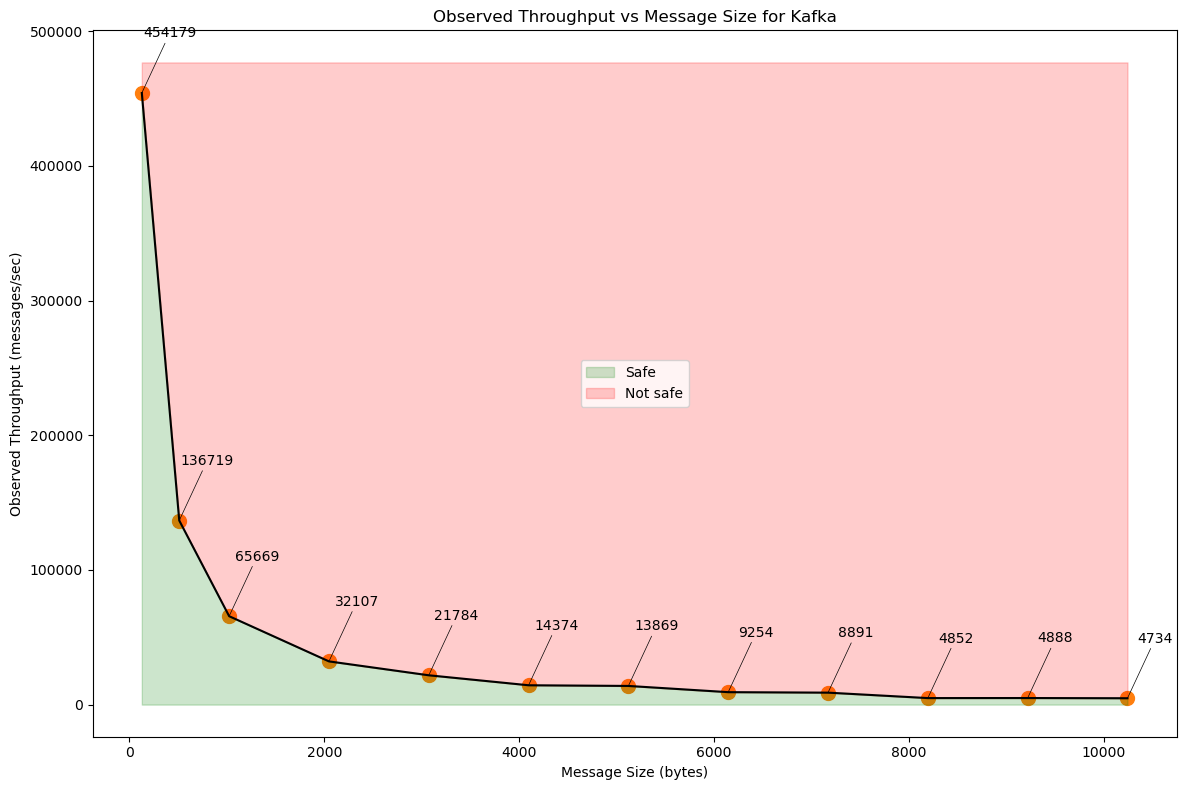

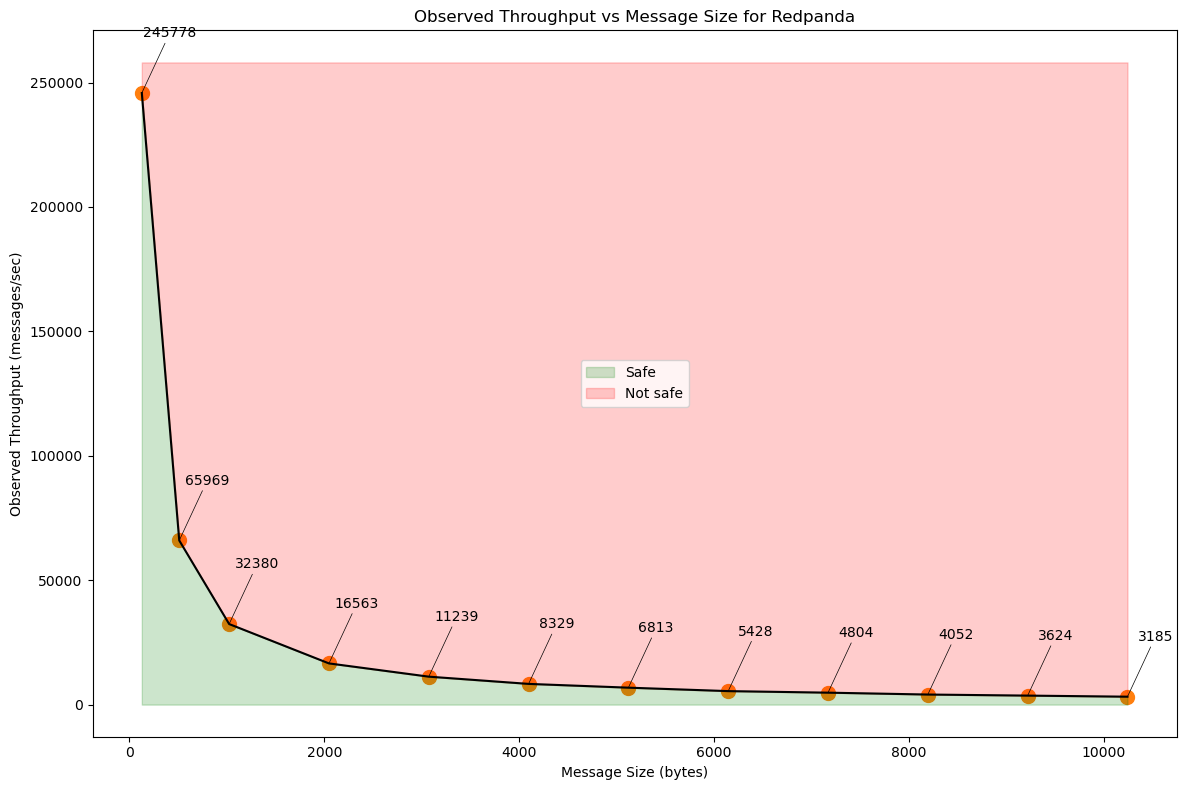

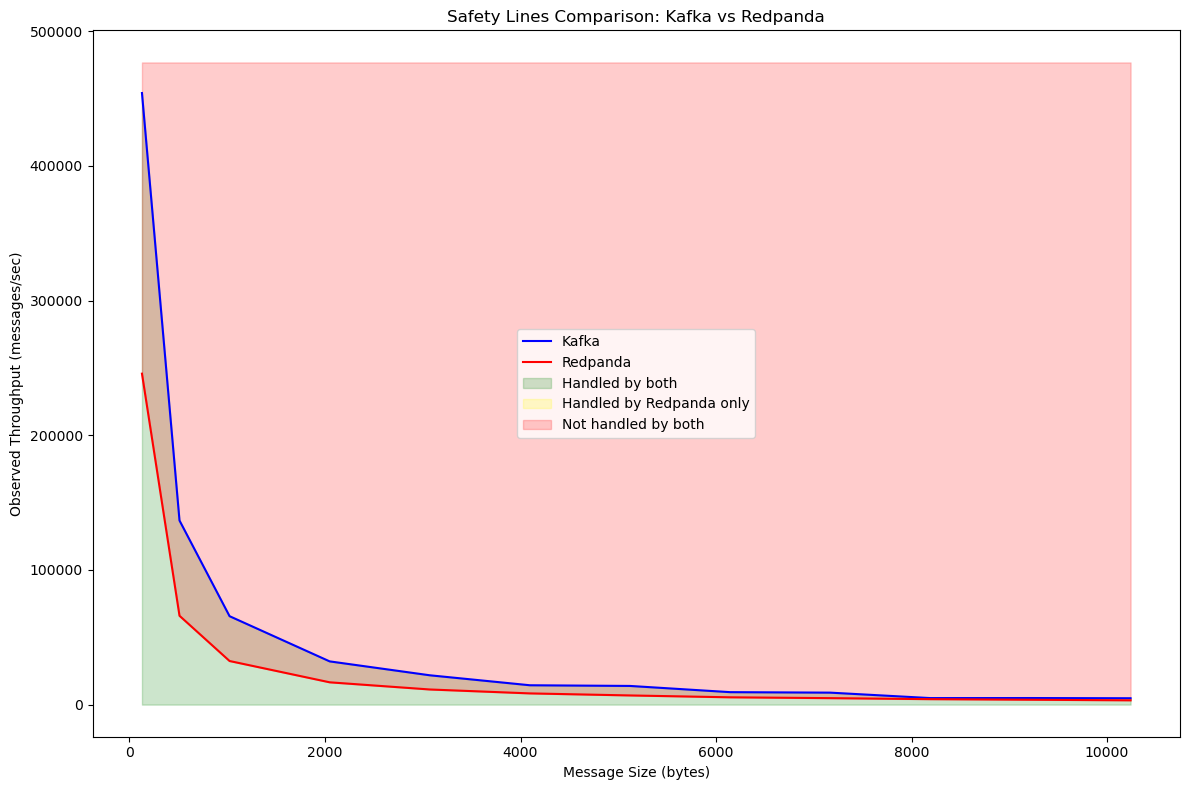

In [7]:
safety_analysis(taurus_1)

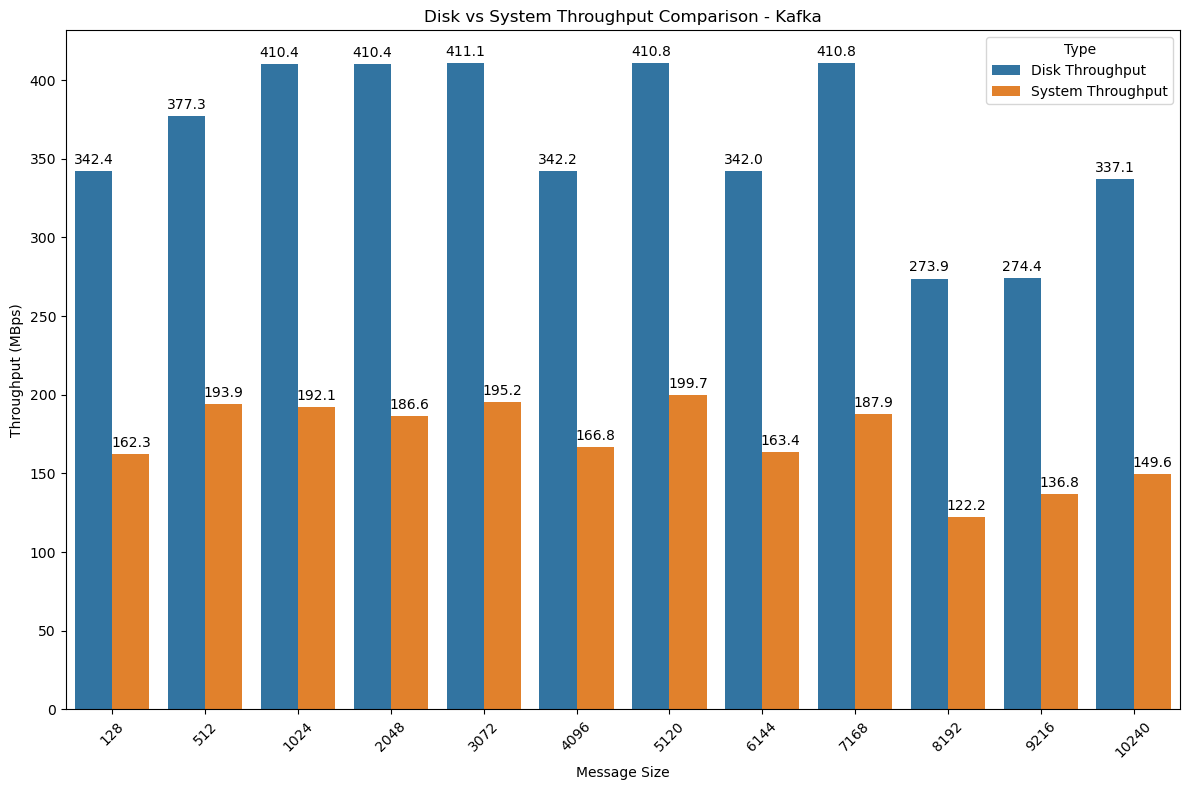

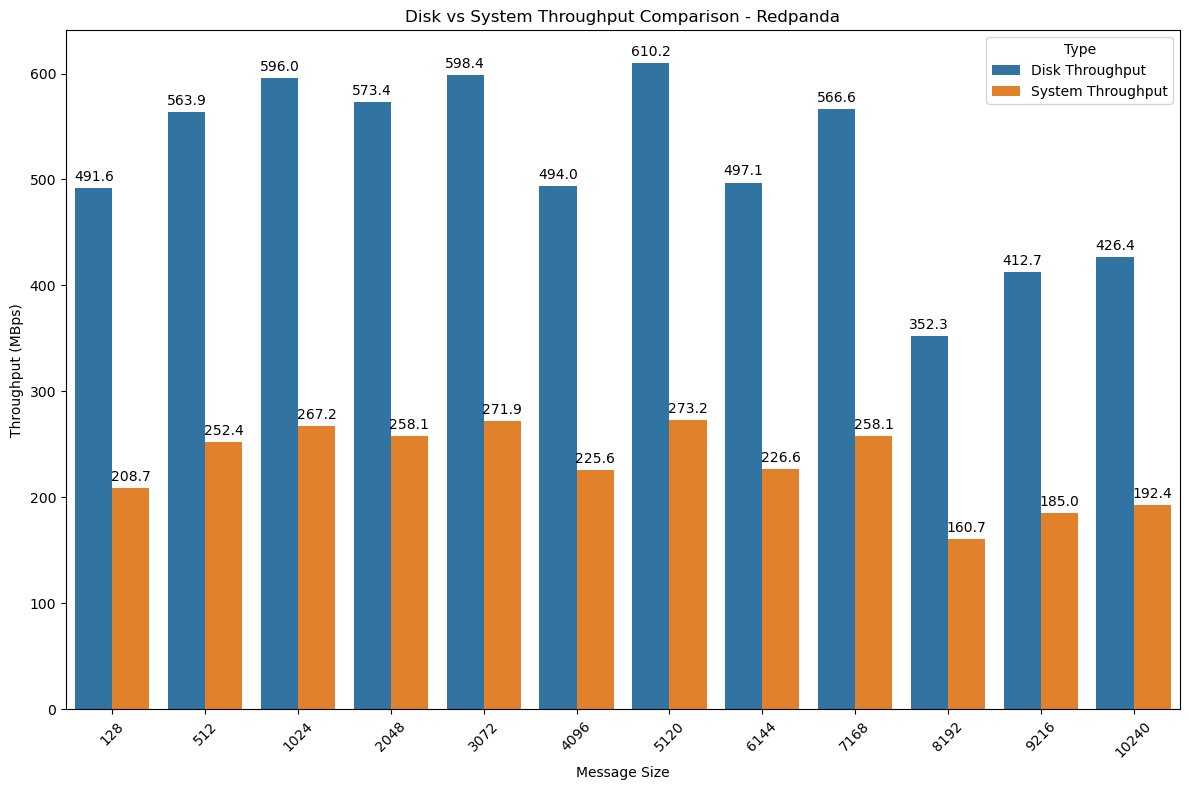

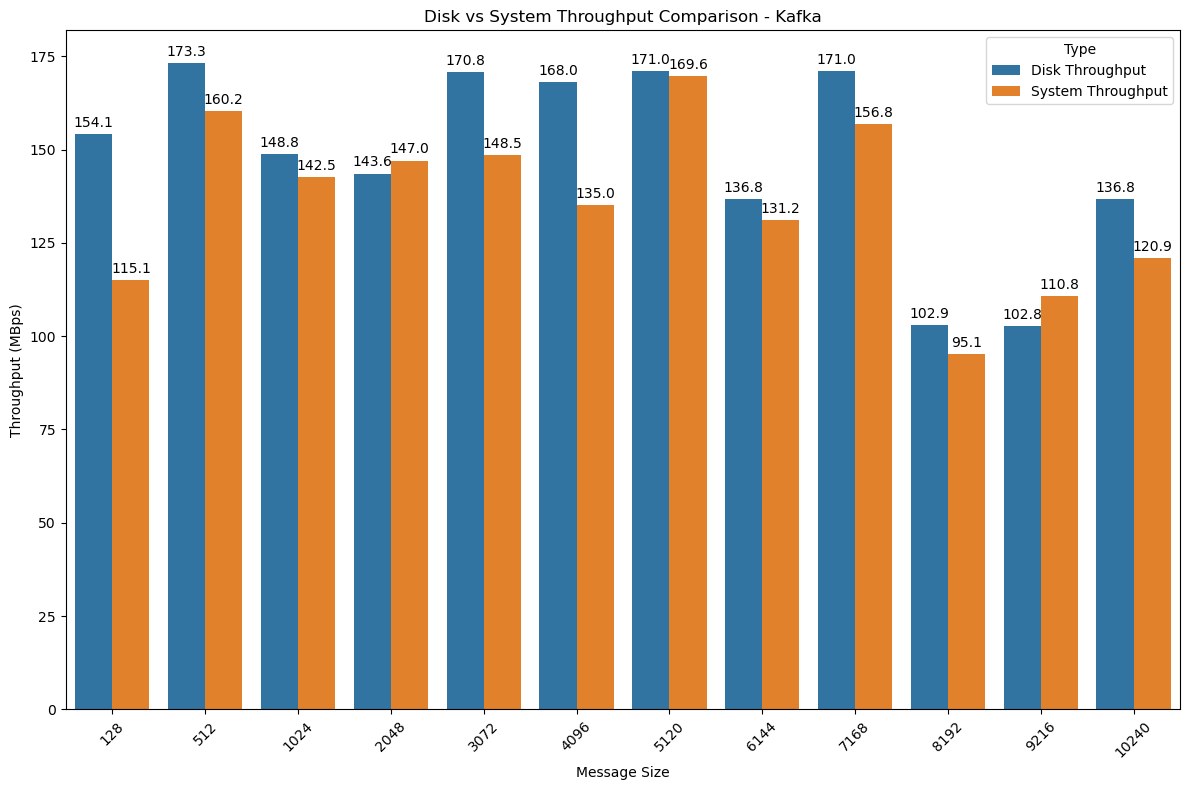

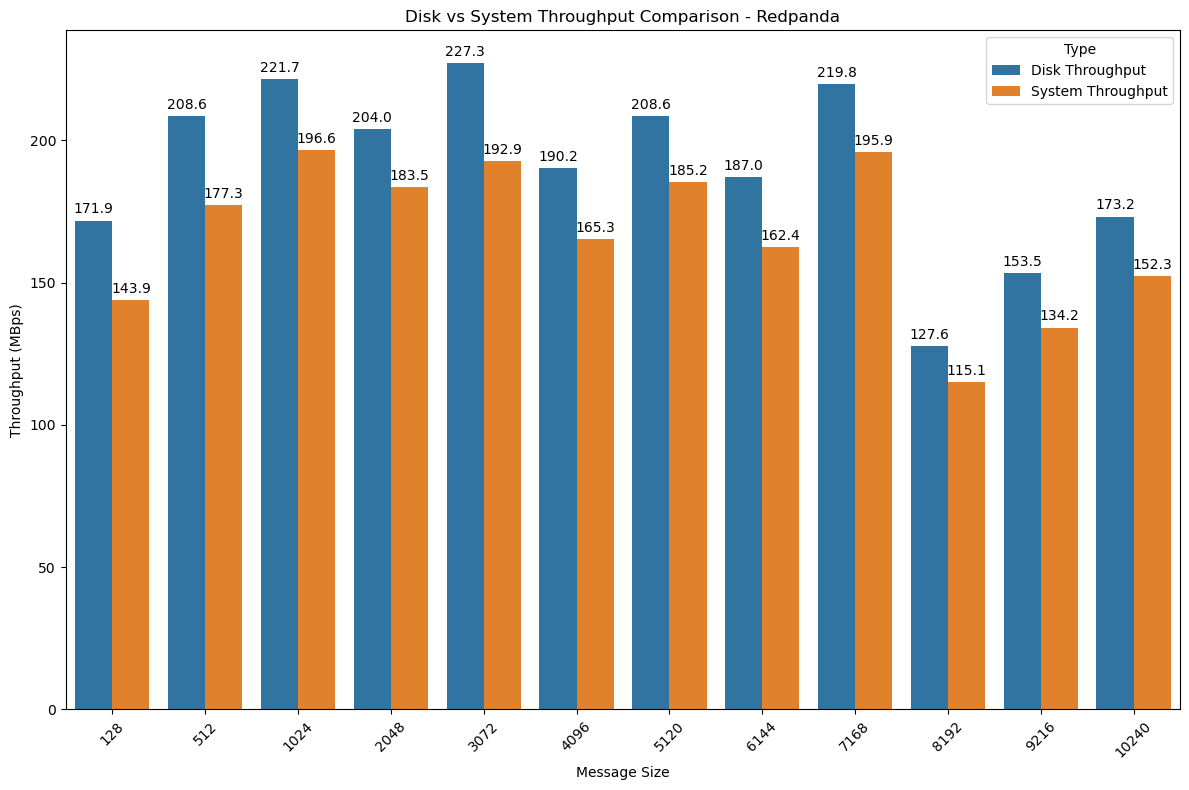

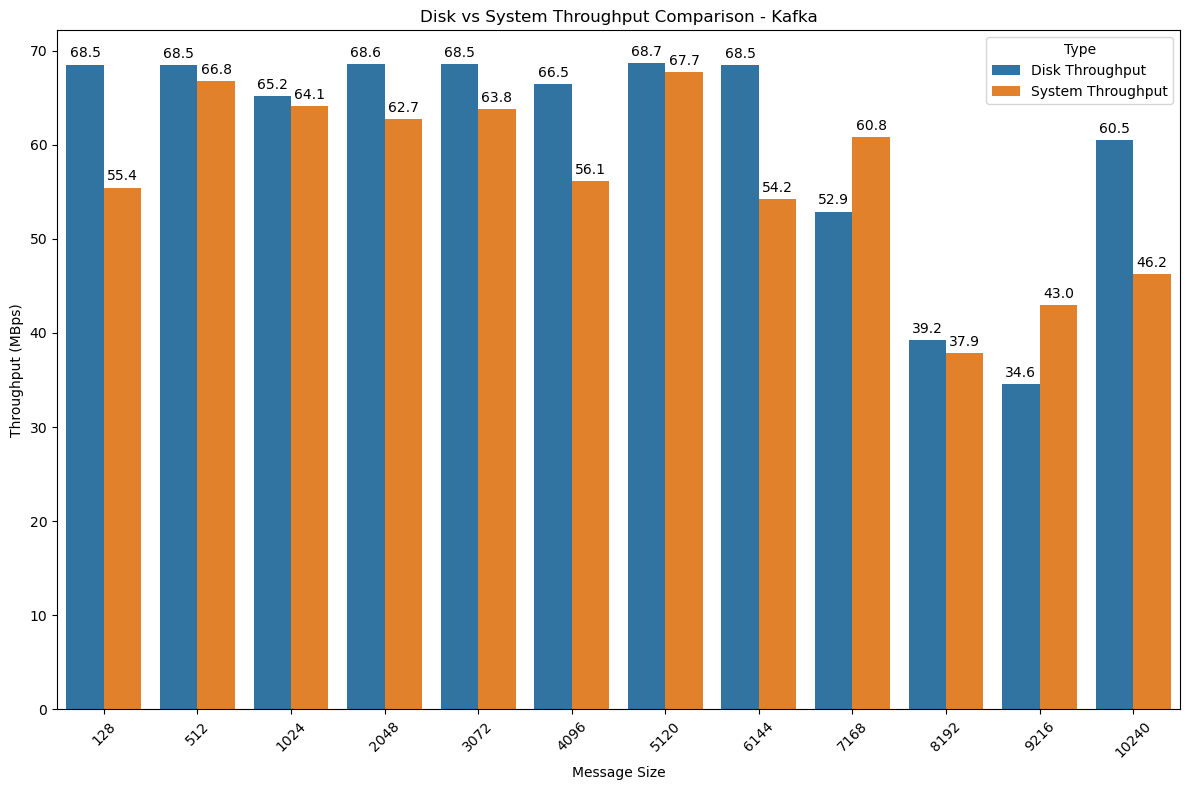

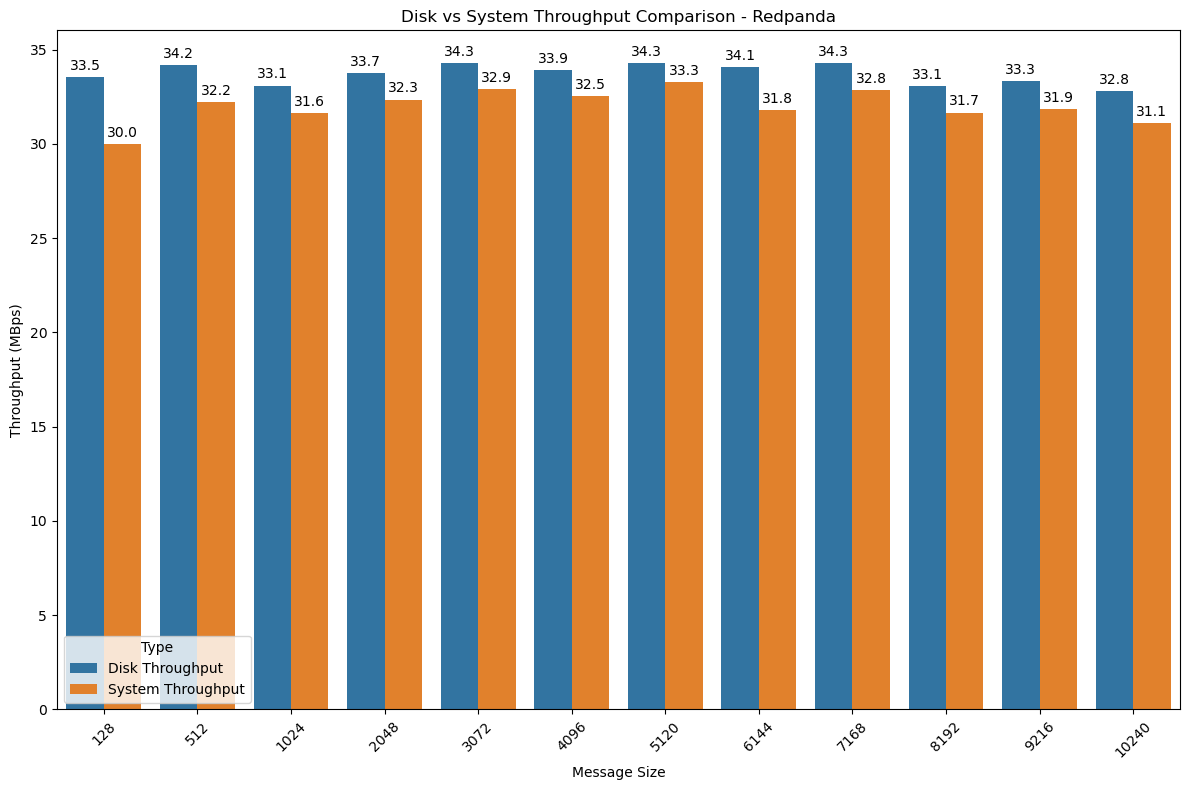

In [8]:
def throughput_comparison(data, system_name):
    # Filter data for the specific system
    system_data = data[data["exp_name"] == f"ingest-{system_name.lower()}"]
    
    # Create figure and axis
    plt.figure(figsize=(12, 8))
    
    # Reshape the data for seaborn
    plot_data = pd.DataFrame([
        {
            'Message Size': row['messageSize'],
            'Throughput (MBps)': value,
            'Type': metric
        }
        for _, row in system_data.iterrows()
        for value, metric in [
            (row['disk_throughput_MBps'], 'Disk Throughput'),
            (row['throughput_MBps'], 'System Throughput')
        ]
    ])
    
    # Create grouped bar plot
    sns.barplot(
        data=plot_data,
        x='Message Size',
        y='Throughput (MBps)',
        hue='Type',
        # palette=['skyblue', 'orange']
    )
    
    # Customize the plot
    plt.title(f'Disk vs System Throughput Comparison - {system_name}')
    plt.xticks(rotation=45)
    
    # Add value labels on top of bars
    ax = plt.gca()
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f', padding=3)
    
    plt.tight_layout()
    plt.show()

# Generate plots for each system and dataset
for dataset in [ovhnvme_1, grappe_1, taurus_1]:
    throughput_comparison(dataset, "Kafka")
    throughput_comparison(dataset, "Redpanda")
